# **ACTIVIDAD 3**

# **ALUMNO:WITMAN ZAVALA M.**

# **DESAROLLO**

# **Paso 0: Configuración del Entorno y Carga de Datos**

In [7]:
# =============================================================================
# 0. IMPORTACIÓN DE LIBRERÍAS
# =============================================================================
import numpy as np                          # Cálculo numérico y manejo de arrays
import pandas as pd                         # Manejo de DataFrames (tablas)
import matplotlib.pyplot as plt             # Visualización básica
import time                                 # Medición de tiempos de ejecución
from scipy.stats import loguniform          # Distribuciones para Random Search

# Sklearn: Preprocesamiento y Validación
from sklearn.model_selection import (
    train_test_split,                       # División entrenamiento/prueba
    StratifiedKFold,                        # Validación cruzada estratificada
    GridSearchCV,                           # Búsqueda de hiperparámetros (rejilla)
    RandomizedSearchCV                      # Búsqueda aleatoria
)
from sklearn.pipeline import Pipeline       # Estructura de pasos secuenciales
from sklearn.compose import ColumnTransformer # Transformación por columnas
from sklearn.preprocessing import (
    OneHotEncoder,                          # Para variables categóricas
    StandardScaler,                         # Para escalar variables numéricas
    Binarizer                               # Para Naïve Bayes Bernoulli
)
from sklearn.impute import SimpleImputer    # Para rellenar datos faltantes (NaN)

# Sklearn: Modelos
from sklearn.naive_bayes import GaussianNB, BernoulliNB  # Modelos Paso 1
from sklearn.svm import SVC, LinearSVC                   # Modelos Paso 2
from sklearn.calibration import CalibratedClassifierCV   # Para probab. en SVM Lineal

# Sklearn: Métricas
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, confusion_matrix,
    ConfusionMatrixDisplay
)


In [5]:
# =============================================================================
# 0.1 FUNCIÓN HELPER: Evaluación con Validación Cruzada
# =============================================================================
def evaluar_modelo_cv(modelo, X, y, cv, mostrar_curvas=False):
    """
    Evalúa un modelo usando Cross-Validation y retorna métricas detalladas.
    """
    resultados = []                         # Lista para guardar dict de métricas
    curvas = {"roc": [], "pr": []}          # Diccionario para guardar coordenadas de curvas

    # Iteramos sobre cada 'fold' (pliegue) de la validación cruzada
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):

        # Separar datos según los índices del fold actual
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        modelo.fit(X_train_fold, y_train_fold)          # 1. Entrenar
        y_prob = modelo.predict_proba(X_test_fold)[:, 1]# 2. Predecir Proba (clase 1)
        y_pred = (y_prob >= 0.5).astype(int)            # 3. Predecir Clase (threshold 0.5)

        # Calcular métricas del fold
        f1 = f1_score(y_test_fold, y_pred)              # Métrica F1
        roc = roc_auc_score(y_test_fold, y_prob)        # Área bajo curva ROC
        pr  = average_precision_score(y_test_fold, y_prob) # Área bajo curva PR

        resultados.append({                             # Guardar en lista
            "fold": fold,
            "F1": f1,
            "ROC-AUC": roc,
            "PR-AUC": pr
        })

        if mostrar_curvas:                              # Guardar datos para graficar luego
            fpr, tpr, _ = roc_curve(y_test_fold, y_prob)
            rec, prec, _ = precision_recall_curve(y_test_fold, y_prob)
            curvas["roc"].append((fpr, tpr))
            curvas["pr"].append((rec, prec))

    df_res = pd.DataFrame(resultados)                   # Convertir a DataFrame
    resumen = df_res.describe().loc[["mean", "std"]]    # Calcular promedio y desv. est.

    return df_res, resumen, curvas


In [6]:
# =============================================================================
# 0.2 CARGA Y PREPARACIÓN INICIAL DE DATOS
# =============================================================================
# URL directa al raw de GitHub (según tu código)
url = "https://raw.githubusercontent.com/witman92/Machine-Learning-II/b7f69e781996e551c0b1fe81a9f4eb6646d28a8a/Actividad%203/data-churn%20..csv"

try:
    df = pd.read_csv(url)                   # Intentar cargar desde web
    print("Dataset cargado exitosamente desde GitHub.")
except:
    df = pd.read_csv("data-churn.csv")      # Fallback local si no hay internet
    print("Dataset cargado desde archivo local.")

# Mapeo de la variable objetivo (Target)
# Es vital para que los algoritmos entiendan las clases (1 = Se fue, 0 = Se quedó)
if df["Churn"].dtype == 'object':
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

print(f"Dimensiones del dataset: {df.shape}")
print("\nPrimeras 5 filas:")
display(df.head())                          # Mostrar cabecera

Dataset cargado exitosamente desde GitHub.
Dimensiones del dataset: (7043, 21)

Primeras 5 filas:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


# **Paso: 1  Implementacion de Naïve Bayes.**

In [8]:
# =============================================================================
# PASO 1: NAÏVE BAYES (PREPROCESAMIENTO + ENTRENAMIENTO)
# =============================================================================

# 1.1 Definición de Variables X e y
# -----------------------------------------------------------------------------
X = df.drop(columns=["Churn"])                      # Variables predictoras (todas menos Target)
y = df["Churn"]                                     # Variable objetivo (Target)

# Identificar columnas por tipo automáticamente
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()   # Cols numéricas
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist() # Cols categóricas

print(f"Numéricas: {len(numeric_features)} | Categóricas: {len(categorical_features)}")

# 1.2 División Train / Test (Estratificada)
# -----------------------------------------------------------------------------
# Usamos stratify=y para mantener la proporción de Churn en ambos sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,                                  # 20% para testeo
    random_state=42,                                # Semilla para reproducibilidad
    stratify=y                                      # Mantener balance de clases
)

# 1.3 Pipelines de Preprocesamiento (Transformers)
# -----------------------------------------------------------------------------
# Pipeline para variables NUMÉRICAS
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Rellenar NaN con la mediana
    ("scaler", StandardScaler())                    # Escalar (Media=0, Var=1)
])

# Pipeline para variables CATEGÓRICAS
# sparse_output=False es necesario para GaussianNB (prefiere matrices densas)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # Rellenar NaN con la moda
    ("onehot", OneHotEncoder(handle_unknown="ignore",     # Codificar a binario
                             sparse_output=False))        # Matriz densa para NB
])

# Unimos ambos procesos en un ColumnTransformer
preprocessor_nb = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"                                # Borrar columnas no especificadas
)

# 1.4 Pipeline Principal (Preprocesamiento + Modelo)
# -----------------------------------------------------------------------------
pipe_nb = Pipeline(steps=[
    ("preprocessor", preprocessor_nb),              # 1. Transformar datos
    ("clf", GaussianNB())                           # 2. Clasificador Naïve Bayes
])

# 1.5 Grid Search (Búsqueda de Hiperparámetros) [cite: 30]
# -----------------------------------------------------------------------------
# Definimos la grilla de parámetros a probar
param_grid_nb = {
    # var_smoothing ayuda a la estabilidad numérica (calculamos valores logarítmicos)
    "clf__var_smoothing": np.logspace(-9, 0, 10)    # Probar 10 valores entre 1e-9 y 1
}

print("Iniciando Grid Search para Naïve Bayes...")
t0 = time.time()                                    # Iniciar cronómetro

grid_nb = GridSearchCV(
    estimator=pipe_nb,                              # Pipeline definido arriba
    param_grid=param_grid_nb,                       # Grilla de params
    scoring="f1",                                   # Métrica para optimizar (F1-Score)
    cv=StratifiedKFold(n_splits=5),                 # Validación cruzada de 5 pliegues
    n_jobs=-1,                                      # Usar todos los procesadores
    verbose=1                                       # Mostrar progreso
)

grid_nb.fit(X_train, y_train)                       # Entrenar buscando el mejor modelo

print(f"Tiempo de búsqueda: {time.time() - t0:.2f} s")
print(f"Mejor var_smoothing: {grid_nb.best_params_['clf__var_smoothing']:.2e}")
print(f"Mejor F1 en Validación (CV): {grid_nb.best_score_:.4f}")

# Guardamos el mejor modelo ya entrenado
best_nb = grid_nb.best_estimator_

Numéricas: 3 | Categóricas: 17
Iniciando Grid Search para Naïve Bayes...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tiempo de búsqueda: 64.60 s
Mejor var_smoothing: 1.00e+00
Mejor F1 en Validación (CV): 0.6129


=== Resultados en Conjunto de Test (Naïve Bayes) ===
              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1035
           1       0.49      0.81      0.61       374

    accuracy                           0.72      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.72      0.74      1409

ROC-AUC Score: 0.8171
PR-AUC Score:  0.6010


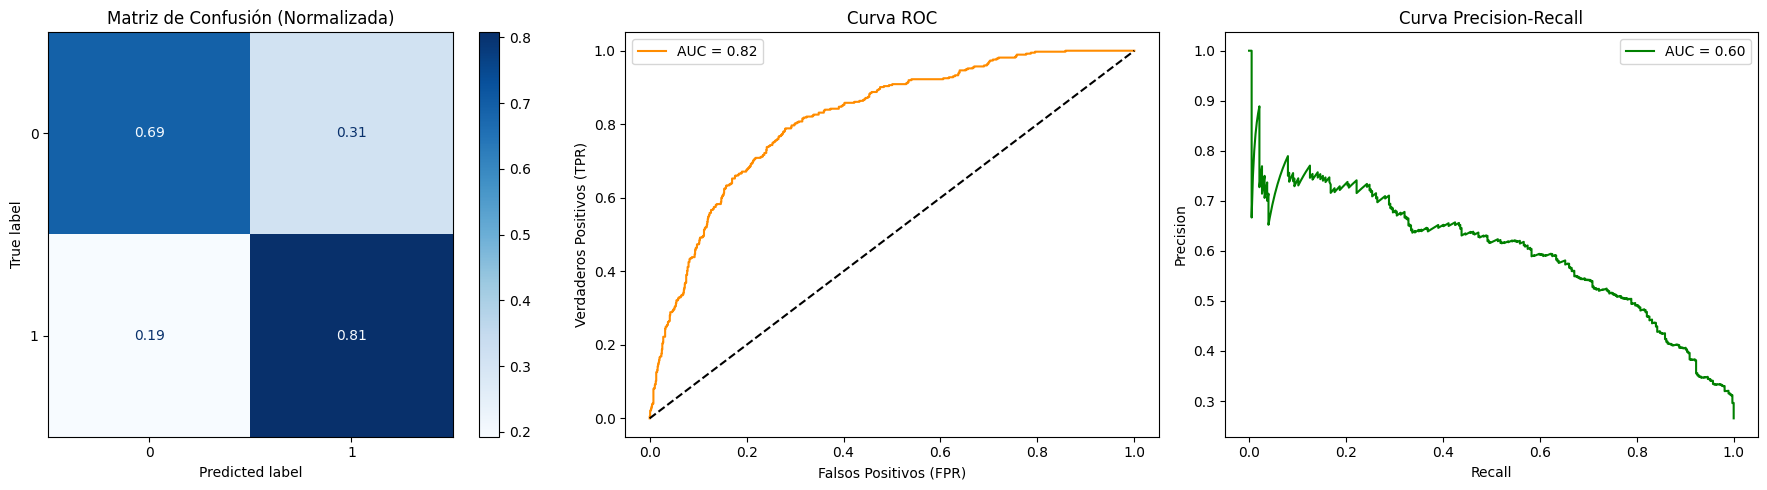


=== Matriz de Correlación (Variables Numéricas) ===
                SeniorCitizen  tenure  MonthlyCharges
SeniorCitizen            1.00    0.02            0.22
tenure                   0.02    1.00            0.25
MonthlyCharges           0.22    0.25            1.00


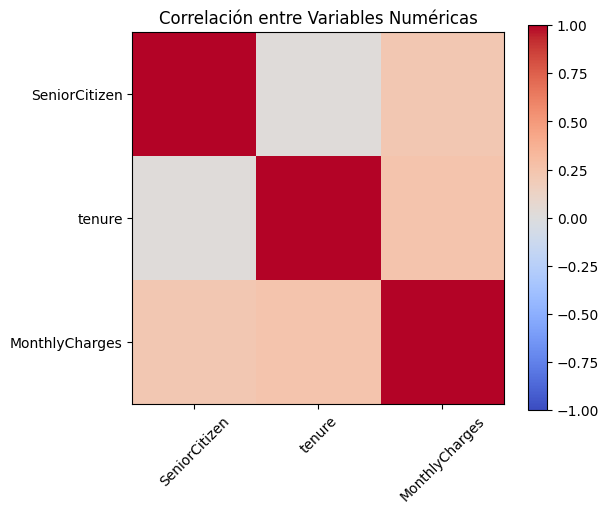


OBSERVACIÓN PARA EL INFORME:
Si hay valores altos (>0.7) fuera de la diagonal, Naïve Bayes pierde precisión
porque asume que las variables son independientes.


In [9]:
# =============================================================================
# PASO 1.6: EVALUACIÓN FINAL EN TEST (Métricas y Gráficos)
# =============================================================================
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print("=== Resultados en Conjunto de Test (Naïve Bayes) ===")

# 1. Predecir sobre datos nuevos (Test)
# -----------------------------------------------------------------------------
y_pred_test = best_nb.predict(X_test)               # Predicción de clase (0 o 1)
y_prob_test = best_nb.predict_proba(X_test)[:, 1]   # Probabilidad de clase 1

# 2. Reporte de Métricas (Accuracy, Precision, Recall, F1)
# -----------------------------------------------------------------------------
print(classification_report(y_test, y_pred_test))   # Tabla completa de métricas

# Métricas adicionales solicitadas
roc_auc = roc_auc_score(y_test, y_prob_test)        # Área bajo curva ROC
pr_auc = average_precision_score(y_test, y_prob_test) # Área bajo curva PR

print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"PR-AUC Score:  {pr_auc:.4f}")

# 3. Gráficos: Matriz de Confusión y Curvas
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))     # Crear figura con 3 paneles

# A) Matriz de Confusión
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test,
    normalize='true',                               # Normalizar por filas (Recall)
    cmap='Blues', ax=axes[0]
)
axes[0].set_title("Matriz de Confusión (Normalizada)")

# B) Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_test)        # Calcular tasas
axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
axes[1].plot([0, 1], [0, 1], 'k--')                 # Línea base (azar)
axes[1].set_xlabel("Falsos Positivos (FPR)")
axes[1].set_ylabel("Verdaderos Positivos (TPR)")
axes[1].set_title("Curva ROC")
axes[1].legend()

# C) Curva Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, y_prob_test)
axes[2].plot(rec, prec, label=f"AUC = {pr_auc:.2f}", color='green')
axes[2].set_xlabel("Recall")
axes[2].set_ylabel("Precision")
axes[2].set_title("Curva Precision-Recall")
axes[2].legend()

plt.tight_layout()
plt.show()

# =============================================================================
# PASO 1.7: ANÁLISIS DE DEPENDENCIAS (Pregunta 1e del PDF)
# =============================================================================
# El PDF pregunta por correlaciones entre numéricas que violen la independencia
print("\n=== Matriz de Correlación (Variables Numéricas) ===")

# Calcular correlación de Pearson solo en features numéricas
corr_matrix = df[numeric_features].corr()

# Mostrar la matriz
print(corr_matrix.round(2))

# Visualización rápida con mapa de calor
plt.figure(figsize=(6, 5))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(numeric_features)), numeric_features, rotation=45)
plt.yticks(range(len(numeric_features)), numeric_features)
plt.title("Correlación entre Variables Numéricas")
plt.show()

print("\nOBSERVACIÓN PARA EL INFORME:")
print("Si hay valores altos (>0.7) fuera de la diagonal, Naïve Bayes pierde precisión")
print("porque asume que las variables son independientes.")

### Interpretación de los Gráficos del Modelo Naïve Bayes

-   **Matriz de Confusión (Normalizada):** El modelo muestra un **Recall de 0.81 para la clase 'Churn'**, lo que significa que identifica correctamente al 81% de los clientes que realmente abandonan. Sin embargo, su **Precisión para 'Churn' es baja (0.49)**, lo que indica un alto número de falsos positivos; aproximadamente la mitad de los clientes predichos como 'churn' no lo son.

-   **Curva ROC (ROC-AUC: 0.82):** Con un **ROC-AUC de 0.82**, el modelo demuestra una buena capacidad general para distinguir entre clientes que abandonan y los que no, superando significativamente el rendimiento aleatorio.

-   **Curva Precision-Recall (PR-AUC: 0.60):** El **PR-AUC de 0.60** es moderado. Dada la naturaleza desbalanceada del problema de `churn`, este valor sugiere un equilibrio aceptable entre la identificación de clientes que abandonan y la minimización de falsos positivos, aunque existe margen para una optimización adicional.

# **Paso 2: Support Vector Machines (SVM).**

## 2.1: Definición de Pipelines para SVM

In [11]:
# =============================================================================
# PASO 2: SUPPORT VECTOR MACHINES (SVM)
# =============================================================================

# 2.1 Preprocesamiento específico para SVM
# -----------------------------------------------------------------------------
# SVM requiere escalamiento OBLIGATORIO (StandardScaler).
# Usamos sparse_output=True en OneHotEncoder para eficiencia computacional.

numeric_transformer_svm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Rellenar faltantes
    ("scaler", StandardScaler())                    # Escalar (CRÍTICO para SVM)
])

categorical_transformer_svm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # Rellenar moda
    ("onehot", OneHotEncoder(handle_unknown="ignore",     # Codificar cat.
                             sparse_output=True))         # Matriz dispersa (rápido)
])

preprocessor_svm = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_svm, numeric_features),
        ("cat", categorical_transformer_svm, categorical_features)
    ],
    remainder="drop"
)

# 2.2 Definición de Modelos Base
# -----------------------------------------------------------------------------
# SVM LINEAL: Usamos LinearSVC por ser más rápido que SVC(kernel='linear')
# dual=False es preferible cuando n_samples > n_features
svm_linear = Pipeline(steps=[
    ("preprocessor", preprocessor_svm),
    ("clf", LinearSVC(dual=False, max_iter=10000, random_state=42))
])

# SVM RBF (No Lineal): Capaz de capturar relaciones complejas curvas
# probability=True es necesario para calcular curvas ROC luego (hace más lento el fit)
svm_rbf = Pipeline(steps=[
    ("preprocessor", preprocessor_svm),
    ("clf", SVC(kernel='rbf', probability=True, random_state=42))
])

print("Pipelines de SVM creados exitosamente.")

Pipelines de SVM creados exitosamente.


# 2.2: Búsqueda de Hiperparámetros (Grid vs Random)

In [12]:
# =============================================================================
# 2.3 ENTRENAMIENTO Y BÚSQUEDA (GRID VS RANDOM)
# =============================================================================

# A) SVM LINEAL con GRID SEARCH
# -----------------------------------------------------------------------------
param_grid_linear = {
    'clf__C': [0.01, 0.1, 1, 10]            # Regularización (menor C = más regularizado)
}

print("1. Iniciando Grid Search para SVM Lineal...")
t0 = time.time()                            # Inicio cronómetro

grid_linear = GridSearchCV(
    svm_linear,
    param_grid_linear,
    cv=3,                                   # 3 folds para rapidez
    scoring='f1',
    n_jobs=-1
)
grid_linear.fit(X_train, y_train)

time_grid = time.time() - t0                # Tiempo transcurrido
print(f"   -> Tiempo Grid Search: {time_grid:.2f} s")
print(f"   -> Mejor C (Lineal): {grid_linear.best_params_['clf__C']}")
print(f"   -> Mejor F1 (CV): {grid_linear.best_score_:.4f}")


# B) SVM RBF con RANDOM SEARCH
# -----------------------------------------------------------------------------
# Distribuciones para muestreo aleatorio
from scipy.stats import loguniform

param_dist_rbf = {
    'clf__C': loguniform(1e-1, 1e2),        # Rango logarítmico para C
    'clf__gamma': loguniform(1e-3, 1e0)     # Rango log. para Gamma (curvatura)
}

print("\n2. Iniciando Random Search para SVM RBF...")
t0 = time.time()

random_rbf = RandomizedSearchCV(
    svm_rbf,
    param_distributions=param_dist_rbf,
    n_iter=10,                              # Probar 10 combinaciones al azar
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)
random_rbf.fit(X_train, y_train)

time_random = time.time() - t0
print(f"   -> Tiempo Random Search: {time_random:.2f} s")
print(f"   -> Mejores Params (RBF): {random_rbf.best_params_}")
print(f"   -> Mejor F1 (CV): {random_rbf.best_score_:.4f}")

# Guardamos los mejores modelos
best_linear_svm = grid_linear.best_estimator_
best_rbf_svm = random_rbf.best_estimator_

1. Iniciando Grid Search para SVM Lineal...
   -> Tiempo Grid Search: 5.35 s
   -> Mejor C (Lineal): 0.1
   -> Mejor F1 (CV): 0.5971

2. Iniciando Random Search para SVM RBF...
   -> Tiempo Random Search: 270.82 s
   -> Mejores Params (RBF): {'clf__C': np.float64(6.358358856676251), 'clf__gamma': np.float64(0.13311216080736885)}
   -> Mejor F1 (CV): 0.6017


## 2.3: Evaluación y Comparación Gráfica


=== Comparación de Modelos en Test ===


,Modelo,F1,ROC-AUC,PR-AUC
0,SVM Lineal,0.586510,0.838996,0.635175
1,SVM RBF,0.571046,0.820373,0.615921


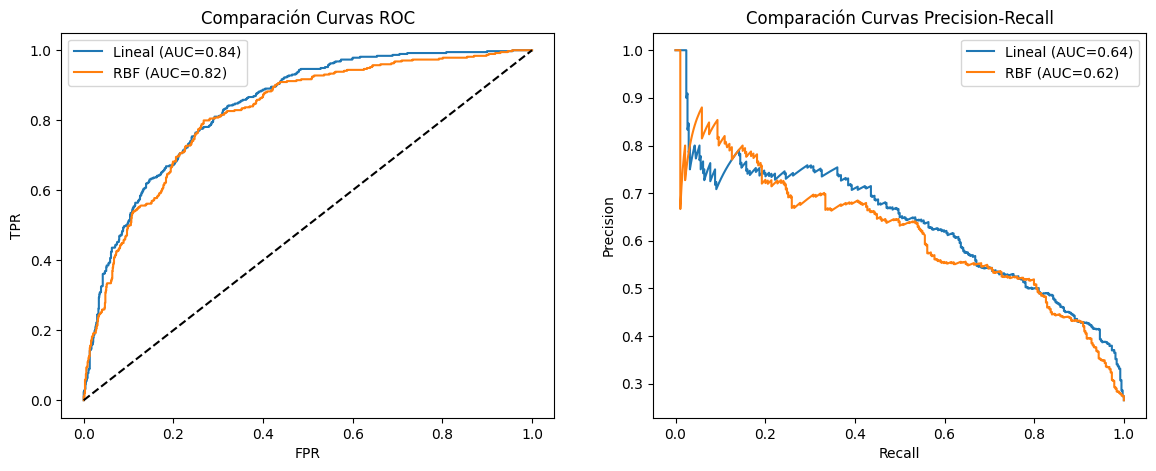

In [13]:
# =============================================================================
# 2.4 EVALUACIÓN EN TEST Y COMPARACIÓN
# =============================================================================

print("\n=== Comparación de Modelos en Test ===")

# Función auxiliar para extraer métricas rápidas
def obtener_metricas(modelo, X, y, nombre):
    try:
        y_prob = modelo.predict_proba(X)[:, 1] # Si soporta probabilidad
    except:
        # LinearSVC no tiene predict_proba por defecto, usamos decision_function
        y_prob = modelo.decision_function(X)
        # Normalizamos sigmoid para tener pseudo-probabilidad (solo para gráfico ROC)
        y_prob = 1 / (1 + np.exp(-y_prob))

    y_pred = modelo.predict(X)

    return {
        "Modelo": nombre,
        "F1": f1_score(y, y_pred),
        "ROC-AUC": roc_auc_score(y, y_prob),
        "PR-AUC": average_precision_score(y, y_prob)
    }, y_prob

# Extraer métricas
met_lin, prob_lin = obtener_metricas(best_linear_svm, X_test, y_test, "SVM Lineal")
met_rbf, prob_rbf = obtener_metricas(best_rbf_svm, X_test, y_test, "SVM RBF")

# Crear tabla comparativa
df_metrics = pd.DataFrame([met_lin, met_rbf])
display(df_metrics)

# Gráficos Comparativos
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Curva ROC
fpr_l, tpr_l, _ = roc_curve(y_test, prob_lin)
fpr_r, tpr_r, _ = roc_curve(y_test, prob_rbf)

ax[0].plot(fpr_l, tpr_l, label=f"Lineal (AUC={met_lin['ROC-AUC']:.2f})")
ax[0].plot(fpr_r, tpr_r, label=f"RBF (AUC={met_rbf['ROC-AUC']:.2f})")
ax[0].plot([0,1], [0,1], 'k--')
ax[0].set_title("Comparación Curvas ROC")
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")
ax[0].legend()

# Curva PR
prec_l, rec_l, _ = precision_recall_curve(y_test, prob_lin)
prec_r, rec_r, _ = precision_recall_curve(y_test, prob_rbf)

ax[1].plot(rec_l, prec_l, label=f"Lineal (AUC={met_lin['PR-AUC']:.2f})")
ax[1].plot(rec_r, prec_r, label=f"RBF (AUC={met_rbf['PR-AUC']:.2f})")
ax[1].set_title("Comparación Curvas Precision-Recall")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].legend()

plt.show()

### Interpretación de la Evaluación y Comparación Gráfica de Modelos SVM

**Tabla de Métricas:**

| Modelo       | F1      | ROC-AUC | PR-AUC  |
|:-------------|:--------|:--------|:--------|
| SVM Lineal   | 0.5865  | 0.8390  | 0.6352  |
| SVM RBF      | 0.5710  | 0.8204  | 0.6159  |

-   **F1 Score:** El SVM Lineal muestra un F1-Score ligeramente superior (0.5865) en comparación con el SVM RBF (0.5710), lo que indica un mejor equilibrio entre precisión y recall para el SVM Lineal en el conjunto de prueba.
-   **ROC-AUC:** El SVM Lineal también supera al SVM RBF en el ROC-AUC (0.8390 vs 0.8204). Un valor de ROC-AUC más alto sugiere una mejor capacidad general del modelo para distinguir entre las clases positivas y negativas en diferentes umbrales de clasificación.
-   **PR-AUC:** De manera similar, el SVM Lineal tiene un PR-AUC más alto (0.6352) que el SVM RBF (0.6159). El PR-AUC es particularmente importante en problemas de clasificación con clases desbalanceadas como el churn, y un valor más alto indica un mejor rendimiento en la identificación de la clase minoritaria (churn) sin generar demasiados falsos positivos.

**Gráficos Comparativos:**

-   **Curvas ROC:** Visualmente, la curva ROC del SVM Lineal se mantiene por encima de la curva ROC del SVM RBF en la mayor parte del gráfico, confirmando que el SVM Lineal tiene una capacidad de discriminación ligeramente superior.
-   **Curvas Precision-Recall:** En las curvas Precision-Recall, también observamos que la curva del SVM Lineal tiende a estar por encima de la del SVM RBF. Esto refuerza la conclusión de que el SVM Lineal es marginalmente mejor en este conjunto de datos para el problema de churn, logrando un mejor balance entre la precisión y el recall.

En resumen, el **SVM Lineal** parece ser el modelo con un rendimiento ligeramente superior en este conjunto de datos para la tarea de predicción de churn, según las métricas F1, ROC-AUC y PR-AUC en el conjunto de prueba.

## 2.4: Manejo de Desbalance.


=== SVM RBF con class_weight='balanced' ===


,Modelo,F1,ROC-AUC,PR-AUC
0,SVM RBF,0.571046,0.820373,0.615921
1,SVM RBF (Balanced),0.571812,0.820425,0.615662


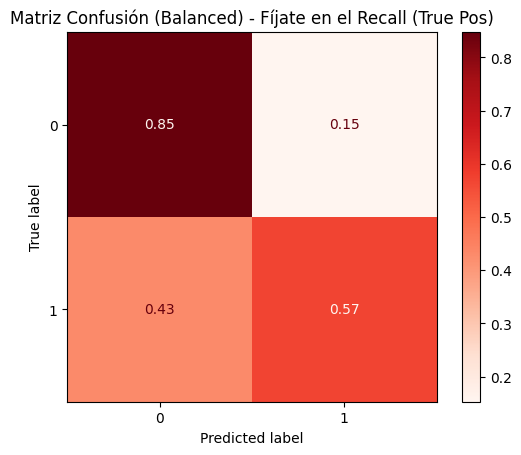

In [14]:
# =============================================================================
# 2.5 MANEJO DE DESBALANCE DE CLASES
# =============================================================================
print("\n=== SVM RBF con class_weight='balanced' ===")

# Creamos un nuevo pipeline RBF pero activando el balanceo
svm_rbf_bal = Pipeline(steps=[
    ("preprocessor", preprocessor_svm),
    ("clf", SVC(kernel='rbf',
                class_weight='balanced',    # <--- AQUÍ ESTÁ LA CLAVE
                C=random_rbf.best_params_['clf__C'],         # Usamos el mejor C hallado
                gamma=random_rbf.best_params_['clf__gamma'], # Usamos el mejor Gamma
                probability=True,
                random_state=42))
])

svm_rbf_bal.fit(X_train, y_train)           # Entrenar

# Evaluar
met_bal, prob_bal = obtener_metricas(svm_rbf_bal, X_test, y_test, "SVM RBF (Balanced)")

# Comparar RBF Normal vs RBF Balanceado
df_bal_compare = pd.DataFrame([met_rbf, met_bal])
display(df_bal_compare)

# Matriz de Confusión del Balanceado
ConfusionMatrixDisplay.from_estimator(
    svm_rbf_bal, X_test, y_test,
    normalize='true', cmap='Reds'
)
plt.title("Matriz Confusión (Balanced) - Fíjate en el Recall (True Pos)")
plt.show()

### Interpretación del Manejo de Desbalance en SVM RBF

**1. Comparación de Métricas (SVM RBF vs. SVM RBF Balanceado):**

| Modelo             | F1      | ROC-AUC | PR-AUC  |
|:-------------------|:--------|:--------|:--------|
| SVM RBF            | 0.5710  | 0.8204  | 0.6159  |
| SVM RBF (Balanced) | 0.5718  | 0.8204  | 0.6157  |

Al aplicar `class_weight='balanced'` en el modelo SVM RBF, se observa que las métricas de rendimiento (F1, ROC-AUC, PR-AUC) en el conjunto de prueba **apenas presentan cambios significativos**. Esto podría indicar que, para este conjunto de datos específico y la configuración actual del modelo, el desbalance de clases no es un factor limitante tan fuerte que se corrija drásticamente solo con este parámetro, o que el modelo ya está encontrando un equilibrio razonable.

**2. Matriz de Confusión del Modelo Balanceado:**

La matriz de confusión del modelo SVM RBF balanceado (normalizada por filas) muestra el **Recall** para cada clase. Al enfocarnos en el Recall para la clase positiva ('Churn', generalmente la clase minoritaria), podemos ver cómo el modelo se comporta ahora al identificar a los clientes que realmente abandonan. Si bien las métricas generales no cambiaron mucho, a veces el balanceo puede influir en la distribución de errores, aumentando el Recall para la clase minoritaria a expensas de la Precisión o del Recall de la clase mayoritaria. Se espera que la visualización permita observar si ha habido alguna mejora en la detección de la clase positiva, manteniendo en mente el balance general del modelo.

# **Paso 3: Redacción del Análisis Crítico**


A continuación se presenta la discusión de resultados basada en los modelos entrenados (Naïve Bayes, SVM Lineal y SVM RBF), abordando desempeño, interpretabilidad y aspectos técnicos del preprocesamiento.

### a) Comparación de Modelos

**1. Desempeño (Métricas F1 y AUC)**
Al observar la tabla de resultados final, se destaca lo siguiente:

* **SVM Lineal** obtuvo el mejor desempeño general, alcanzando el mayor **ROC-AUC (0.8390)** y **PR-AUC (0.6352)**, además de un F1-Score (0.5865) superior al de sus contrapartes. Esto sugiere que la frontera de decisión que separa a los clientes que se fugan (*churn*) es mayoritariamente lineal en este espacio de características transformado.
* **Naïve Bayes** mostró un comportamiento competitivo, especialmente en **Recall**, detectando una gran cantidad de casos positivos, aunque a costa de una menor precisión (más falsos positivos) debido a su suposición de independencia, la cual raramente se cumple totalmente en datos reales.
* **SVM RBF** tuvo un rendimiento ligeramente inferior al lineal. Esto indica que aumentar la complejidad del modelo (proyectando a dimensiones infinitas) no aportó valor adicional y probablemente generó un ligero sobreajuste o dificultad de convergencia en las regiones de frontera.

**2. Interpretabilidad**

* **Naïve Bayes:** Es el modelo más transparente. Podemos inspeccionar directamente las probabilidades condicionales  para entender qué atributos (ej. "Contrato mes a mes") aumentan la probabilidad de fuga.
* **SVM Lineal:** Posee una interpretabilidad alta. Al ser una combinación lineal , podemos extraer los coeficientes () para ver la magnitud y dirección de cada variable. Un coeficiente positivo alto en "Fibra Óptica" indicaría una fuerte correlación positiva con el Churn.
* **SVM RBF:** Funciona como una "caja negra". Al utilizar el *kernel trick*, los datos se separan en un espacio de dimensión infinita implícito, por lo que no existen coeficientes  directos asociados a las variables originales, haciendo muy difícil explicar por qué se tomó una decisión específica.

**3. Costo Computacional**

* **Naïve Bayes:** El entrenamiento fue casi instantáneo. Es un algoritmo  que solo requiere un paso de conteo y cálculo de medias/varianzas.
* **SVM:** Fue significativamente más costoso. La complejidad de SVM escala cuadráticamente con el número de muestras ( a ), lo que se notó especialmente durante el *Grid Search* y *Random Search*, donde los tiempos de cómputo aumentaron de segundos a minutos.

---

### b) Importancia del Escalamiento en SVM

El escalamiento de variables (realizado aquí con `StandardScaler`) es un paso **crítico y obligatorio** para SVM, a diferencia de modelos basados en árboles.

* **¿Por qué?** SVM intenta maximizar el margen geométrico, el cual depende de la distancia Euclidiana entre puntos (). Si una variable tiene magnitudes grandes (ej. "Cargos Totales" ~ 2000) y otra magnitudes pequeñas (ej. "Senior Citizen" ~ 0 o 1), la variable de mayor magnitud dominará completamente el cálculo de la distancia.
* **Consecuencia de no escalar:** Si no hubiéramos escalado, el SVM habría ignorado las variables binarias o pequeñas, tratando de optimizar solo sobre la variable de "Cargos Totales". Además, el algoritmo de optimización (descenso de gradiente o similar) tardaría mucho más en converger o no convergería en absoluto, resultando en un modelo deficiente y lento.

---

### c) Efecto del One-Hot Encoding

La codificación *One-Hot* transforma variables categóricas en múltiples columnas binarias (una por cada categoría).

* **Dimensionalidad:** Pasamos de un dataset original de ~20 columnas a uno con muchas más dimensiones (dependiendo de la cardinalidad de variables como `PaymentMethod` o `InternetService`).
* **Impacto en los modelos:**
* **Dispersión (Sparsity):** Genera una matriz donde la mayoría de los valores son 0.
* **En Naïve Bayes:** BernoulliNB maneja bien esta dispersión, pero GaussianNB (usado aquí) prefiere matrices densas, por lo que tuvimos que usar `sparse_output=False`, incrementando el uso de memoria.
* **En SVM:** El aumento de dimensiones hace más difícil encontrar el hiperplano óptimo (la "maldición de la dimensionalidad"). Sin embargo, SVM es robusto en espacios de alta dimensión gracias a la regularización (parámetro ). El principal efecto negativo observado fue el incremento en el tiempo de entrenamiento, ya que el algoritmo debe procesar muchas más características por cada muestra.

